In [1]:
import gc
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from atmacup_18 import constants

import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_20_01/utils.py'>

In [2]:
RANDOM_STATE = 2024
utils.seed_everything(RANDOM_STATE)

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]
TRAFFIC_LIGHTS_BBOX_IMAGE_NAME = constants.TRAFFIC_LIGHT_BBOX_IMAGE_NAME
OPTICAL_FLOW_IMAGE_NAME = constants.OPTICAL_FLOW_IMAGE_NAME

BASE_PRED_DIR = Path("..", "..", "..", "main2", "v00", "v00_04_00")
BASE_OOF_PRED_CSV = BASE_PRED_DIR.joinpath("oof_preds.csv")
BASE_SUBMISSION_CSV = BASE_PRED_DIR.joinpath("submission.csv")

In [4]:
TARGET_COLS = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

In [5]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320,0
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…",420,1


In [6]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1


In [7]:
def reduce_base_pred(
    df: pl.DataFrame, base_pred_df: pl.DataFrame, has_target: bool
) -> pl.DataFrame:
    """
    基礎推定値のdfをconcatし、元のdfのtarget列から除去したdfを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        base_pred_df (pl.DataFrame): 基礎推定値のDataFrame
        has_target (bool): target列を持つかどうか
    """
    pf = "base_pred_"
    df = pl.concat(
        [df, base_pred_df.select(pl.all().name.prefix(pf))], how="horizontal"
    )

    if has_target:
        target_cols = TARGET_COLS
        df = df.with_columns(
            [
                (pl.col(tg_col) - pl.col(f"{pf}{tg_col}")).alias(tg_col)
                for tg_col in target_cols
            ]
        )
    return df


def add_base_pred_to_target(df: pl.DataFrame, target_cols: list[str]) -> pl.DataFrame:
    """
    target_colsの列に基礎推定量を足したDataFrameを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        target_cols (list[str]): 追加する基礎推定量の列名
    """
    pf = "base_pred_"
    base_pred_cols = [f"{pf}{tg_col}" for tg_col in TARGET_COLS]
    df = df.with_columns(
        [
            (pl.col(tg_col) + pl.col(bp_col)).alias(tg_col)
            for tg_col, bp_col in zip(target_cols, base_pred_cols)
        ]
    )

    return df


if BASE_PRED_DIR is not None:
    # columns: "x_0", "y_0", "z_0", ..., "x_5", "y_5", "z_5"
    base_oof_pred_df = pl.read_csv(BASE_OOF_PRED_CSV)
    base_submission_df = pl.read_csv(BASE_SUBMISSION_CSV)

    # 基礎推定値を元のtarget列から引いた値を新たなtarget列とする
    tr_df = reduce_base_pred(tr_df, base_oof_pred_df, has_target=True)
    ts_df = reduce_base_pred(ts_df, base_submission_df, has_target=False)

    del base_oof_pred_df
    gc.collect()

    del base_submission_df
    gc.collect()

In [8]:
tr_tl_bbox_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=tr_df.get_column("ID").to_list(),
    image_names=[TRAFFIC_LIGHTS_BBOX_IMAGE_NAME],
)
print(tr_tl_bbox_images.shape)
ts_tl_bbox_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=ts_df.get_column("ID").to_list(),
    image_names=[TRAFFIC_LIGHTS_BBOX_IMAGE_NAME],
)
print(ts_tl_bbox_images.shape)

(43371, 1, 64, 128, 8)
(1727, 1, 64, 128, 8)


In [9]:
# tr_optical_flow_images = utils.load_npy_images(
#    IMAGES_DIR,
#    ids=tr_df.get_column("ID").to_list(),
#    image_names=[OPTICAL_FLOW_IMAGE_NAME],
# )
# print(tr_optical_flow_images.shape)
# ts_optical_flow_images = utils.load_npy_images(
#    IMAGES_DIR,
#    ids=ts_df.get_column("ID").to_list(),
#    image_names=[OPTICAL_FLOW_IMAGE_NAME],
# )
# print(ts_optical_flow_images.shape)

In [10]:
tr_images = utils.load_images(
    IMAGES_DIR, ids=tr_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(tr_images.shape)
ts_images = utils.load_images(
    IMAGES_DIR, ids=ts_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(ts_images.shape)

(43371, 3, 64, 128, 3)
(1727, 3, 64, 128, 3)


In [11]:
tr_images = utils.preprocess_images(
    # [tr_images, tr_tl_bbox_images, tr_optical_flow_images]
    [tr_images, tr_tl_bbox_images]
    # [tr_images]
)
ts_images = utils.preprocess_images(
    # [ts_images, ts_tl_bbox_images, ts_optical_flow_images]
    [ts_images, ts_tl_bbox_images]
    # [ts_images]
)

print(tr_images.shape)
print(ts_images.shape)

(43371, 17, 64, 128)
(1727, 17, 64, 128)


In [12]:
# del tr_tl_bbox_images
# gc.collect()
#
# del ts_tl_bbox_images
# gc.collect()
#
# del tr_optical_flow_images
# gc.collect()
#
# del ts_optical_flow_images
# gc.collect()

## scene_dsec順に並び替える

In [13]:
tr_df = tr_df.sort(["scene_id", "scene_dsec"])
ts_df = ts_df.sort(["scene_id", "scene_dsec"])

tr_images = tr_images[tr_df.get_column("origin_idx").to_numpy()]
ts_images = ts_images[ts_df.get_column("origin_idx").to_numpy()]

## Target

In [14]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

del tg_df
gc.collect()

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, -6.398172096493292e-05, 0.09748330055151712, -2.049703424044697, -0.03889588129092658, -0.0004598591444684372, 0.04074949288609275, 1.1879026061010576
$ tg_cood_y_0 <f64> 43371.0, 0.0, -1.8151129571594546e-05, 0.06193532851615388, -2.548924091006372, -0.022029638339427435, -0.0006609180929956013, 0.02146723659824248, 3.8037482134210494
$ tg_cood_z_0 <f64> 43371.0, 0.0, 8.790075275766784e-06, 0.04012050718886584, -0.9958970690087603, -0.018423500383461567, 0.0003501801640828847, 0.01789679478671308, 1.444553594762872
$ tg_cood_x_1 <f64> 43371.0, 0.0, 7.390598477211262e-05, 0.19

0

## 特徴量

In [15]:
feature = utils.Feature(prefix="ft_")
feature.fit(tr_df)

ft_df = feature.transform(tr_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

del ft_df
gc.collect()

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker', 'ft_base_pred_x0', 'ft_base_pred_y0', 'ft_base_pred_z0', 'ft_base_pred_x1', 'ft_base_pred_y1', 'ft_base_pred_z1', 'ft_base_pred_x2', 'ft_base_pred_y2', 'ft_base_pred_z2', 'ft_base_pred_x3', 'ft_base_pred_y3', 'ft_base_pred_z3', 'ft_base_pred_x4', 'ft_base_pred_y4', 'ft_base_pred_z4', 'ft_base_pred_x5', 'ft_base_pred_y5', 'ft_base_pred_z5']
Rows: 9
Columns: 33
$ statistic                 <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ ft_vEgo                   <f64> 43371.0, 0.0, 9.172175823216334, 7.226919878374694, -0.1619189828634262, 2.5786657333374023, 8.518790245056152, 14.286815643310547, 27.55126190185547
$ ft_aEgo                   <f64> 43371.0, 0.0, -0.015654028629347255, 0.63

0

## モデリング

In [16]:
N_SPLITS = 2

In [17]:
n_sample_in_scene = 3

model_params = {
    "dnn": {
        "n_sample_in_scene": n_sample_in_scene,
        "n_img_channels": tr_images.shape[1] * n_sample_in_scene,
        "n_features": len(feature.columns) * n_sample_in_scene,
        "n_targets": len(target.columns),
        "segmentation_model_params": {
            "encoder_name": "mit_b1",
            "encoder_weights": "imagenet",
            "decoder_channels": (256, 128, 64, 32, 16),
        },
        "dropout": 0.0,
        "embed_dim": 128,
        "n_layers": 1,
    },
    "dnn_pretrained_model": {
        # list[str]: len(list) == n_splits
        "weight_path": None,
        "load_only_backbone": None,
    },
    "dev": "cuda",
}

lr = 5e-5
fit_params = {
    "dnn": {
        "tr_batch_size": 32,
        "vl_batch_size": 1024,
        "trainer_params": {
            "criterion_params": {},
            "opt": "adamw",
            "opt_params": {"lr": lr, "weight_decay": 1e-4},
            "backbone_opt_params": {"lr": lr, "weight_decay": 1e-4},
            "sch_params": {
                "max_lr": lr,
                "pct_start": 0.1,
                "div_factor": 25,
                "final_div_factor": 1000,
            },
            "epochs": 9,
            "dev": "cuda",
            "val_freq": 1,
            "prefix": "",
            "save_best": False,
            "save_epochs": [],
            "maximize_score": False,
            "grad_max_norm": None,
            "mixup_alpha": 2.0,
        },
    },
}

In [18]:
models, oof_preds = utils.train(
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    images=tr_images,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    scene_id_col="scene_id",
    scene_dsec_col="scene_dsec",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
Save model : fold0_model.pth

epoch  0
lr  2.000000000000001e-06
lr  2.000000000000001e-06
lr  2.000000000000001e-06
lr  2.000000000000001e-06


100%|██████████| 22/22 [00:14<00:00,  1.57it/s]



Train Loss: 3.7795
{'loss': 3.7795186868622523, 'loss_mse_0': 0.06367003922096208, 'loss_mse_1': 0.04221735392151018, 'loss_mse_2': 0.027316697736296865, 'loss_mse_3': 0.12835965222201723, 'loss_mse_4': 0.07899738855018903, 'loss_mse_5': 0.0545662738303028, 'loss_mse_6': 0.21710887458037856, 'loss_mse_7': 0.12849857210232554, 'loss_mse_8': 0.0907591625971051, 'loss_mse_9': 0.3386484638758917, 'loss_mse_10': 0.21248287765620114, 'loss_mse_11': 0.11403004778067594, 'loss_mse_12': 0.4815033983378678, 'loss_mse_13': 0.33196947461701215, 'loss_mse_14': 0.14693523786048593, 'loss_mse_15': 0.6613912585699048, 'loss_mse_16': 0.48488074862446356, 'loss_mse_17': 0.17618316525326522}
Valid Loss: 5.7937
{'loss': 5.79373819177801, 'loss_mse_0': 0.10368210483681072, 'loss_mse_1': 0.07141068154437975, 'loss_mse_2': 0.03856121198358861, 'loss_mse_3': 0.21487694098190827, 'loss_mse_4': 0.13371026583693243, 'loss_mse_5': 0.07817395878109065, 'loss_mse_6': 0.3391629606485367, 'loss_mse_7': 0.21087766167

100%|██████████| 22/22 [00:12<00:00,  1.75it/s]



Train Loss: 3.7116
{'loss': 3.7116201409913234, 'loss_mse_0': 0.060932321296495826, 'loss_mse_1': 0.04233585648648606, 'loss_mse_2': 0.02610265662373653, 'loss_mse_3': 0.1234622777906003, 'loss_mse_4': 0.07863918775788878, 'loss_mse_5': 0.05363691253023582, 'loss_mse_6': 0.20892503284237057, 'loss_mse_7': 0.12907503318025054, 'loss_mse_8': 0.08165614973296971, 'loss_mse_9': 0.32766924356076005, 'loss_mse_10': 0.2106082453344298, 'loss_mse_11': 0.11079811814627671, 'loss_mse_12': 0.47705912868460665, 'loss_mse_13': 0.3281064453360073, 'loss_mse_14': 0.141141682978791, 'loss_mse_15': 0.6553022569180239, 'loss_mse_16': 0.4830471888305606, 'loss_mse_17': 0.17312239243633815}
Valid Loss: 5.7556
{'loss': 5.755605762655085, 'loss_mse_0': 0.10343303633007137, 'loss_mse_1': 0.07127864497967741, 'loss_mse_2': 0.03844436393542723, 'loss_mse_3': 0.21157846261154523, 'loss_mse_4': 0.132483803413131, 'loss_mse_5': 0.07790961929342964, 'loss_mse_6': 0.33544977280226623, 'loss_mse_7': 0.2084648324684

100%|██████████| 22/22 [00:11<00:00,  1.93it/s]



Train Loss: 3.7195
{'loss': 3.719513972717691, 'loss_mse_0': 0.060909954166559824, 'loss_mse_1': 0.04119647687928341, 'loss_mse_2': 0.026469825303382852, 'loss_mse_3': 0.1237078117457063, 'loss_mse_4': 0.0772736004376275, 'loss_mse_5': 0.054089230804413864, 'loss_mse_6': 0.20817635522019035, 'loss_mse_7': 0.12822509402109303, 'loss_mse_8': 0.08206025252402092, 'loss_mse_9': 0.32670917891329115, 'loss_mse_10': 0.21049603037371065, 'loss_mse_11': 0.11152554602201263, 'loss_mse_12': 0.4778603438282471, 'loss_mse_13': 0.3289600147190263, 'loss_mse_14': 0.14176752578956867, 'loss_mse_15': 0.660168193170644, 'loss_mse_16': 0.48676604879923724, 'loss_mse_17': 0.1731524836585652}
Valid Loss: 5.7773
{'loss': 5.777288025075739, 'loss_mse_0': 0.10662399537184021, 'loss_mse_1': 0.0714968829839067, 'loss_mse_2': 0.03941438169303266, 'loss_mse_3': 0.21448220177130264, 'loss_mse_4': 0.13306436179713768, 'loss_mse_5': 0.0788347079333934, 'loss_mse_6': 0.33669058639894833, 'loss_mse_7': 0.209772903810

100%|██████████| 22/22 [00:11<00:00,  1.85it/s]



Train Loss: 3.7820
{'loss': 3.7819656818620917, 'loss_mse_0': 0.06507095754933453, 'loss_mse_1': 0.03618994158688531, 'loss_mse_2': 0.02778713596968236, 'loss_mse_3': 0.13058484033399442, 'loss_mse_4': 0.07362885835774496, 'loss_mse_5': 0.05647815898077307, 'loss_mse_6': 0.2159724262772758, 'loss_mse_7': 0.12619162009453933, 'loss_mse_8': 0.08604659310967126, 'loss_mse_9': 0.3357431917139047, 'loss_mse_10': 0.20876730949324906, 'loss_mse_11': 0.11607556592018249, 'loss_mse_12': 0.4899025866142756, 'loss_mse_13': 0.326717541650752, 'loss_mse_14': 0.14749708508954354, 'loss_mse_15': 0.6756375495625035, 'loss_mse_16': 0.4837586077444663, 'loss_mse_17': 0.17991570711818192}
Valid Loss: 5.6447
{'loss': 5.644658890637484, 'loss_mse_0': 0.10328382287513126, 'loss_mse_1': 0.07142281168225137, 'loss_mse_2': 0.0384258423847231, 'loss_mse_3': 0.21132207661867142, 'loss_mse_4': 0.1306755356490612, 'loss_mse_5': 0.07756754078648308, 'loss_mse_6': 0.3350941775874658, 'loss_mse_7': 0.201896278018301

100%|██████████| 22/22 [00:11<00:00,  1.96it/s]



Train Loss: 3.8218
{'loss': 3.8218218121606102, 'loss_mse_0': 0.06575898606841903, 'loss_mse_1': 0.039568726566277634, 'loss_mse_2': 0.027082909010708377, 'loss_mse_3': 0.13108792212933434, 'loss_mse_4': 0.07599282047905281, 'loss_mse_5': 0.05531134836628835, 'loss_mse_6': 0.22069688559546957, 'loss_mse_7': 0.1272234247978144, 'loss_mse_8': 0.08372833783376517, 'loss_mse_9': 0.3455817749066226, 'loss_mse_10': 0.20857007529151844, 'loss_mse_11': 0.11347002920693273, 'loss_mse_12': 0.5050671445302104, 'loss_mse_13': 0.3256356680278764, 'loss_mse_14': 0.14438982475741574, 'loss_mse_15': 0.6967913803797177, 'loss_mse_16': 0.4797146287217098, 'loss_mse_17': 0.17614993029872458}
Valid Loss: 5.5601
{'loss': 5.5601372502066875, 'loss_mse_0': 0.10341938517310402, 'loss_mse_1': 0.07114529982209206, 'loss_mse_2': 0.038565755313770336, 'loss_mse_3': 0.2106118066744371, 'loss_mse_4': 0.1300885724750432, 'loss_mse_5': 0.0777846539223736, 'loss_mse_6': 0.3339467001232234, 'loss_mse_7': 0.19890471344

100%|██████████| 22/22 [00:11<00:00,  1.96it/s]



Train Loss: 3.9580
{'loss': 3.957960666370533, 'loss_mse_0': 0.06990544138368951, 'loss_mse_1': 0.04494302922741481, 'loss_mse_2': 0.029388133341520805, 'loss_mse_3': 0.13910726824585498, 'loss_mse_4': 0.08180137846805981, 'loss_mse_5': 0.05972928473481047, 'loss_mse_6': 0.2320853265516867, 'loss_mse_7': 0.13220836380647943, 'loss_mse_8': 0.09063051086458401, 'loss_mse_9': 0.3606050769018458, 'loss_mse_10': 0.21009207092654758, 'loss_mse_11': 0.12226714822498083, 'loss_mse_12': 0.5254400312966575, 'loss_mse_13': 0.3217579158053264, 'loss_mse_14': 0.1548108763145379, 'loss_mse_15': 0.7247683793922647, 'loss_mse_16': 0.4703337911246798, 'loss_mse_17': 0.18808664586202434}
Valid Loss: 5.5220
{'loss': 5.5220489068464795, 'loss_mse_0': 0.1041236472400752, 'loss_mse_1': 0.07095842681486499, 'loss_mse_2': 0.038641000843860886, 'loss_mse_3': 0.21301314776593988, 'loss_mse_4': 0.1292129656807943, 'loss_mse_5': 0.07748732089319012, 'loss_mse_6': 0.3353862152858214, 'loss_mse_7': 0.1953254856846

100%|██████████| 22/22 [00:11<00:00,  1.99it/s]



Train Loss: 4.0686
{'loss': 4.068619398986219, 'loss_mse_0': 0.07257469469045827, 'loss_mse_1': 0.04404152871936318, 'loss_mse_2': 0.030954704273277494, 'loss_mse_3': 0.14592286448050812, 'loss_mse_4': 0.08201007278941495, 'loss_mse_5': 0.06260376577121116, 'loss_mse_6': 0.24289164431888385, 'loss_mse_7': 0.1327747048499225, 'loss_mse_8': 0.0943692888778413, 'loss_mse_9': 0.3789677358448417, 'loss_mse_10': 0.2093801443606747, 'loss_mse_11': 0.12658089286533558, 'loss_mse_12': 0.5510206166077047, 'loss_mse_13': 0.3187613539958986, 'loss_mse_14': 0.15984842259343301, 'loss_mse_15': 0.7578074749850804, 'loss_mse_16': 0.4642954296714446, 'loss_mse_17': 0.19381406102632137}
Valid Loss: 5.4663
{'loss': 5.466343749653209, 'loss_mse_0': 0.10332666066559879, 'loss_mse_1': 0.07132366824556481, 'loss_mse_2': 0.03850500988350673, 'loss_mse_3': 0.21029640598730606, 'loss_mse_4': 0.12997773052616554, 'loss_mse_5': 0.07688847929239273, 'loss_mse_6': 0.3328317464752631, 'loss_mse_7': 0.19638225639408

100%|██████████| 22/22 [00:10<00:00,  2.01it/s]



Train Loss: 4.2386
{'loss': 4.238563613490129, 'loss_mse_0': 0.07669722254455441, 'loss_mse_1': 0.04342411307582255, 'loss_mse_2': 0.03386654766645156, 'loss_mse_3': 0.15554195218217426, 'loss_mse_4': 0.08304001986595252, 'loss_mse_5': 0.06824797766346435, 'loss_mse_6': 0.25795050062228164, 'loss_mse_7': 0.13294538730917776, 'loss_mse_8': 0.10309110001896121, 'loss_mse_9': 0.3988000448776665, 'loss_mse_10': 0.20757024495297027, 'loss_mse_11': 0.1375470601539492, 'loss_mse_12': 0.5818725814231214, 'loss_mse_13': 0.3132245014015822, 'loss_mse_14': 0.17284374566889055, 'loss_mse_15': 0.803628336687736, 'loss_mse_16': 0.45908397736586354, 'loss_mse_17': 0.2091882976000383}
Valid Loss: 5.5254
{'loss': 5.525410305369984, 'loss_mse_0': 0.10387380251830275, 'loss_mse_1': 0.07187849740413102, 'loss_mse_2': 0.03873349666934122, 'loss_mse_3': 0.211387154053558, 'loss_mse_4': 0.13139491934667935, 'loss_mse_5': 0.07699264839968899, 'loss_mse_6': 0.33486969565803354, 'loss_mse_7': 0.199795280667868

100%|██████████| 22/22 [00:10<00:00,  2.02it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_20_01/utils.py:1395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe


Train Loss: 4.8038
{'loss': 4.803778477222211, 'loss_mse_0': 0.09136473256241712, 'loss_mse_1': 0.055489206811801105, 'loss_mse_2': 0.039770362171670494, 'loss_mse_3': 0.1805180185962815, 'loss_mse_4': 0.10059296287475168, 'loss_mse_5': 0.07911180096652298, 'loss_mse_6': 0.29761665763451745, 'loss_mse_7': 0.152412413703374, 'loss_mse_8': 0.11852982370361707, 'loss_mse_9': 0.4606896807141107, 'loss_mse_10': 0.22886429515225673, 'loss_mse_11': 0.15773844847694987, 'loss_mse_12': 0.6685203679423213, 'loss_mse_13': 0.33538067564258195, 'loss_mse_14': 0.19782095739791278, 'loss_mse_15': 0.917139246751674, 'loss_mse_16': 0.48403584656678417, 'loss_mse_17': 0.23818297555430776}
Valid Loss: 5.5385
{'loss': 5.538465998389504, 'loss_mse_0': 0.10398020629178394, 'loss_mse_1': 0.07202068546956236, 'loss_mse_2': 0.03878320135514845, 'loss_mse_3': 0.21204439144242893, 'loss_mse_4': 0.13163817064328628, 'loss_mse_5': 0.07711753418499773, 'loss_mse_6': 0.33595187149264594, 'loss_mse_7': 0.20002998547

100%|██████████| 22/22 [00:11<00:00,  1.92it/s]



Train Loss: 3.8063
{'loss': 3.806272118975528, 'loss_mse_0': 0.06635177706504458, 'loss_mse_1': 0.03913738618933622, 'loss_mse_2': 0.025761192721593988, 'loss_mse_3': 0.13457236680830864, 'loss_mse_4': 0.07860084792029558, 'loss_mse_5': 0.0534067749935842, 'loss_mse_6': 0.2211462932045914, 'loss_mse_7': 0.13191044402956698, 'loss_mse_8': 0.07895859913760177, 'loss_mse_9': 0.33611352464385014, 'loss_mse_10': 0.21800868623398872, 'loss_mse_11': 0.11177278600875261, 'loss_mse_12': 0.4880495263343372, 'loss_mse_13': 0.3395181758607156, 'loss_mse_14': 0.14328852035600467, 'loss_mse_15': 0.6641387574517744, 'loss_mse_16': 0.5014299430184209, 'loss_mse_17': 0.17410652551860542}
Valid Loss: 5.9358
{'loss': 5.93576396595348, 'loss_mse_0': 0.09498415057632056, 'loss_mse_1': 0.09282200512560931, 'loss_mse_2': 0.04290327632969076, 'loss_mse_3': 0.19131276553327387, 'loss_mse_4': 0.14046952534805646, 'loss_mse_5': 0.08697135627947071, 'loss_mse_6': 0.32983785529028287, 'loss_mse_7': 0.211735961112

100%|██████████| 22/22 [00:10<00:00,  2.00it/s]



Train Loss: 3.6630
{'loss': 3.6630236577776367, 'loss_mse_0': 0.06324423646397526, 'loss_mse_1': 0.04315717399197368, 'loss_mse_2': 0.024535542268696704, 'loss_mse_3': 0.1278661452206278, 'loss_mse_4': 0.07816817471138483, 'loss_mse_5': 0.05096372751109137, 'loss_mse_6': 0.2088694169269971, 'loss_mse_7': 0.12809771075404552, 'loss_mse_8': 0.07777868240433394, 'loss_mse_9': 0.3212861107769622, 'loss_mse_10': 0.2094849065452418, 'loss_mse_11': 0.10605627457381528, 'loss_mse_12': 0.4661917088655108, 'loss_mse_13': 0.32759561416647637, 'loss_mse_14': 0.13524087629056752, 'loss_mse_15': 0.6439744760137893, 'loss_mse_16': 0.48463698872743366, 'loss_mse_17': 0.16587590080640516}
Valid Loss: 5.8312
{'loss': 5.831184127114036, 'loss_mse_0': 0.09043655832382766, 'loss_mse_1': 0.09077012987638061, 'loss_mse_2': 0.04208161199296063, 'loss_mse_3': 0.18378416042436252, 'loss_mse_4': 0.1376722314479676, 'loss_mse_5': 0.08638143861158327, 'loss_mse_6': 0.3197463581507856, 'loss_mse_7': 0.207087558778

100%|██████████| 22/22 [00:10<00:00,  2.02it/s]



Train Loss: 3.7487
{'loss': 3.748721849795106, 'loss_mse_0': 0.06438254280513815, 'loss_mse_1': 0.04671239074143516, 'loss_mse_2': 0.026443529966943505, 'loss_mse_3': 0.13090436201834257, 'loss_mse_4': 0.08293849064870855, 'loss_mse_5': 0.05280582557406216, 'loss_mse_6': 0.2164088231146864, 'loss_mse_7': 0.13176546391358315, 'loss_mse_8': 0.08002056667314322, 'loss_mse_9': 0.331898329209982, 'loss_mse_10': 0.2116120554825932, 'loss_mse_11': 0.10846558316133399, 'loss_mse_12': 0.4815891651736581, 'loss_mse_13': 0.32866782454589444, 'loss_mse_14': 0.13818889975745885, 'loss_mse_15': 0.6625756339405277, 'loss_mse_16': 0.48403521480817385, 'loss_mse_17': 0.16930716307599927}
Valid Loss: 5.7638
{'loss': 5.763812043450096, 'loss_mse_0': 0.09115799973634156, 'loss_mse_1': 0.0905457568270239, 'loss_mse_2': 0.042181066745384174, 'loss_mse_3': 0.18316925046118823, 'loss_mse_4': 0.13691730323162946, 'loss_mse_5': 0.08639689501036298, 'loss_mse_6': 0.31841686977581546, 'loss_mse_7': 0.20234890146

100%|██████████| 22/22 [00:11<00:00,  1.99it/s]



Train Loss: 3.7510
{'loss': 3.751049876917412, 'loss_mse_0': 0.06512267932714, 'loss_mse_1': 0.04360629818498527, 'loss_mse_2': 0.026186818208826082, 'loss_mse_3': 0.13149312080229403, 'loss_mse_4': 0.07995196020002292, 'loss_mse_5': 0.05364432311761282, 'loss_mse_6': 0.21659085080247686, 'loss_mse_7': 0.12896495181489379, 'loss_mse_8': 0.08164720782154464, 'loss_mse_9': 0.33409166540757945, 'loss_mse_10': 0.2084658910414449, 'loss_mse_11': 0.11101227263305088, 'loss_mse_12': 0.48429458185568164, 'loss_mse_13': 0.3251930775184135, 'loss_mse_14': 0.14156757996168587, 'loss_mse_15': 0.6661353151216288, 'loss_mse_16': 0.4794788349480361, 'loss_mse_17': 0.17360244869382466}
Valid Loss: 5.7719
{'loss': 5.7719174515117295, 'loss_mse_0': 0.09053158760070801, 'loss_mse_1': 0.09095770289952104, 'loss_mse_2': 0.04229158357801763, 'loss_mse_3': 0.1843632845716043, 'loss_mse_4': 0.1364181050184098, 'loss_mse_5': 0.08636129512028261, 'loss_mse_6': 0.3206071670759808, 'loss_mse_7': 0.20255724950270

100%|██████████| 22/22 [00:10<00:00,  2.04it/s]



Train Loss: 3.8977
{'loss': 3.897707532392471, 'loss_mse_0': 0.06853557640254673, 'loss_mse_1': 0.04145461256289786, 'loss_mse_2': 0.027073661896827986, 'loss_mse_3': 0.1406856365887066, 'loss_mse_4': 0.08263493904863185, 'loss_mse_5': 0.05524950488257267, 'loss_mse_6': 0.23061014936364735, 'loss_mse_7': 0.13353755824719082, 'loss_mse_8': 0.08420116989495043, 'loss_mse_9': 0.3530488540494107, 'loss_mse_10': 0.2132472014618677, 'loss_mse_11': 0.11444504913960638, 'loss_mse_12': 0.5127308639192862, 'loss_mse_13': 0.3289313909200129, 'loss_mse_14': 0.14587693728583603, 'loss_mse_15': 0.703724559479045, 'loss_mse_16': 0.4826635010485459, 'loss_mse_17': 0.1790563556499108}
Valid Loss: 5.7035
{'loss': 5.703522660515525, 'loss_mse_0': 0.09112482196228071, 'loss_mse_1': 0.0903096010231159, 'loss_mse_2': 0.042063142342323605, 'loss_mse_3': 0.1834826571020213, 'loss_mse_4': 0.1353076303547079, 'loss_mse_5': 0.0860293810679154, 'loss_mse_6': 0.31863716651092877, 'loss_mse_7': 0.1981862343170426,

100%|██████████| 22/22 [00:10<00:00,  2.03it/s]



Train Loss: 4.0112
{'loss': 4.011158789278309, 'loss_mse_0': 0.0707654702728903, 'loss_mse_1': 0.0464053030072146, 'loss_mse_2': 0.028144963274804802, 'loss_mse_3': 0.14584652080504634, 'loss_mse_4': 0.08444262114511679, 'loss_mse_5': 0.057935097608357626, 'loss_mse_6': 0.23870103107971666, 'loss_mse_7': 0.13584682922342592, 'loss_mse_8': 0.0879608798783102, 'loss_mse_9': 0.36614904046454844, 'loss_mse_10': 0.2159328747766321, 'loss_mse_11': 0.11937447528367205, 'loss_mse_12': 0.5296811181584172, 'loss_mse_13': 0.33216246153108303, 'loss_mse_14': 0.151596143462061, 'loss_mse_15': 0.727578212868868, 'loss_mse_16': 0.4869087243802086, 'loss_mse_17': 0.1857270227203165}
Valid Loss: 5.6356
{'loss': 5.635617949745872, 'loss_mse_0': 0.0901310516690666, 'loss_mse_1': 0.0901686218990521, 'loss_mse_2': 0.0420750460841439, 'loss_mse_3': 0.18232174285433508, 'loss_mse_4': 0.13462317091497508, 'loss_mse_5': 0.08599813790483908, 'loss_mse_6': 0.317184061489322, 'loss_mse_7': 0.19658398458903487, '

100%|██████████| 22/22 [00:10<00:00,  2.02it/s]



Train Loss: 4.0934
{'loss': 4.093379225829503, 'loss_mse_0': 0.0771177307134453, 'loss_mse_1': 0.046335422634759274, 'loss_mse_2': 0.031066488374184208, 'loss_mse_3': 0.15538671903829454, 'loss_mse_4': 0.08807450562765054, 'loss_mse_5': 0.06236981553612951, 'loss_mse_6': 0.2510460064838609, 'loss_mse_7': 0.1359585337120726, 'loss_mse_8': 0.09397398857633683, 'loss_mse_9': 0.3808241129537805, 'loss_mse_10': 0.2092880272200576, 'loss_mse_11': 0.126912221945327, 'loss_mse_12': 0.5475764182262794, 'loss_mse_13': 0.3175182431562084, 'loss_mse_14': 0.1610286860964763, 'loss_mse_15': 0.7493072198800181, 'loss_mse_16': 0.46281348813759876, 'loss_mse_17': 0.1967816066156462}
Valid Loss: 5.7278
{'loss': 5.727801431309093, 'loss_mse_0': 0.09034320932220329, 'loss_mse_1': 0.09100719321180474, 'loss_mse_2': 0.04224937290630557, 'loss_mse_3': 0.18262574550780383, 'loss_mse_4': 0.13771879097277467, 'loss_mse_5': 0.0861193033104593, 'loss_mse_6': 0.3171115429563956, 'loss_mse_7': 0.20549352196129886,

100%|██████████| 22/22 [00:10<00:00,  2.00it/s]



Train Loss: 4.3586
{'loss': 4.35863751234649, 'loss_mse_0': 0.08413596775250694, 'loss_mse_1': 0.05010401335939699, 'loss_mse_2': 0.032346216893646224, 'loss_mse_3': 0.1686904423676178, 'loss_mse_4': 0.09433463632515693, 'loss_mse_5': 0.0654320148063309, 'loss_mse_6': 0.2731204475090458, 'loss_mse_7': 0.14369953048182996, 'loss_mse_8': 0.09931271976379999, 'loss_mse_9': 0.4167632258096861, 'loss_mse_10': 0.21671192800320763, 'loss_mse_11': 0.13414542859301873, 'loss_mse_12': 0.598916500179507, 'loss_mse_13': 0.3228230177035536, 'loss_mse_14': 0.1694235199267262, 'loss_mse_15': 0.8190458192320835, 'loss_mse_16': 0.46348334694806725, 'loss_mse_17': 0.20614872412258095}
Valid Loss: 5.6648
{'loss': 5.664792927828702, 'loss_mse_0': 0.09059695577756925, 'loss_mse_1': 0.09077913618900559, 'loss_mse_2': 0.04231942351907492, 'loss_mse_3': 0.1835551695390181, 'loss_mse_4': 0.13633714226836507, 'loss_mse_5': 0.08617652410810644, 'loss_mse_6': 0.31905606524510816, 'loss_mse_7': 0.2001490979032083

100%|██████████| 22/22 [00:10<00:00,  2.02it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_20_01/utils.py:1395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe


Train Loss: 4.9115
{'loss': 4.911457902043398, 'loss_mse_0': 0.096846045164097, 'loss_mse_1': 0.06166052720763967, 'loss_mse_2': 0.03879189789928, 'loss_mse_3': 0.19409482866701736, 'loss_mse_4': 0.10854507919450454, 'loss_mse_5': 0.07774443444871568, 'loss_mse_6': 0.3123638012296516, 'loss_mse_7': 0.15694130131179684, 'loss_mse_8': 0.1167975613652031, 'loss_mse_9': 0.4763090584091457, 'loss_mse_10': 0.2299590266008409, 'loss_mse_11': 0.1567700084964669, 'loss_mse_12': 0.6846272512676093, 'loss_mse_13': 0.33800869921505716, 'loss_mse_14': 0.19769082203001181, 'loss_mse_15': 0.9400427932665302, 'loss_mse_16': 0.4832509452067151, 'loss_mse_17': 0.24101381966819438}
Valid Loss: 5.7010
{'loss': 5.701000798832286, 'loss_mse_0': 0.09080136736685579, 'loss_mse_1': 0.09113059954887087, 'loss_mse_2': 0.04239552010866729, 'loss_mse_3': 0.1839405962012031, 'loss_mse_4': 0.13706424629146402, 'loss_mse_5': 0.08641557869586078, 'loss_mse_6': 0.31963877041231503, 'loss_mse_7': 0.202455804429271, 'lo

In [19]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,…,ft_rightBlinker,ft_base_pred_x0,ft_base_pred_y0,ft_base_pred_z0,ft_base_pred_x1,ft_base_pred_y1,ft_base_pred_z1,ft_base_pred_x2,ft_base_pred_y2,ft_base_pred_z2,ft_base_pred_x3,ft_base_pred_y3,ft_base_pred_z3,ft_base_pred_x4,ft_base_pred_y4,ft_base_pred_z4,ft_base_pred_x5,ft_base_pred_y5,ft_base_pred_z5,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,0.172395,0.032218,0.036811,0.282029,0.078501,0.086588,0.226963,0.170487,0.159554,0.012575,0.290691,0.22269,-0.072305,0.413937,0.287722,-0.07002,0.534906,0.325914,"""00066be8e20318869c38c66be46663…",320,0,2.657195,0.000008,0.008376,5.94997,…,0.0,2.657195,0.000008,0.008376,5.94997,-0.012606,0.021386,9.558046,-0.045516,0.044096,13.472897,-0.127242,0.080128,17.646532,-0.239648,0.118609,22.02129,-0.335403,0.159165,0.006512,-0.012089,0.015239,0.00636,0.000453,0.036779,0.027186,-0.001571,0.098826,0.075398,0.020893,0.098751,0.116924,-0.051866,0.131386,0.190922,-0.015828,0.194014
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,-0.041278,0.039053,-0.006395,-0.16835,0.140279,-0.048352,-0.21264,0.399326,-0.033776,-0.232599,0.847243,-0.020559,-0.344188,1.487704,-0.001991,-0.48685,2.212598,0.007995,"""00066be8e20318869c38c66be46663…",420,1,5.011545,-0.046989,0.011422,10.518838,…,1.0,5.011545,-0.046989,0.011422,10.518838,-0.172653,0.027651,15.982694,-0.315253,0.042421,21.365014,-0.4559,0.056894,26.660678,-0.64458,0.066991,31.870663,-0.787528,0.065088,0.006717,-0.009097,0.004942,0.030811,-0.034938,0.001168,0.065515,-0.095983,-0.013751,0.066772,-0.215239,-0.036636,0.124754,-0.394885,-0.029611,0.152624,-0.609211,-0.062501
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,0.086445,0.019216,0.017866,0.075239,0.042648,0.023752,-0.066262,-0.016731,0.03294,-0.328948,-0.10076,0.043167,-0.73832,-0.16282,0.079025,-1.414526,-0.243566,0.122579,"""00066be8e20318869c38c66be46663…",520,2,4.729256,-0.020029,-0.000288,10.078283,…,0.0,4.729256,-0.020029,-0.000288,10.078283,-0.070449,0.002413,15.512801,-0.139256,0.007458,20.947108,-0.256173,0.015598,26.415708,-0.414164,0.023833,31.874558,-0.598328,0.03031,0.007737,-0.033507,-0.000663,0.034,-0.099643,-0.010591,0.024994,-0.223109,-0.018598,0.075158,-0.378086,-0.025715,0.068294,-0.711415,-0.031731,0.12972,-1.13865,-0.063103
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,-0.003906,-0.003164,-0.010747,0.015751,-0.018886,-0.02198,0.035797,-0.049081,-0.035394,0.071458,-0.096728,-0.039579,0.08842,-0.139843,-0.038498,0.200804,-0.154587,-0.031748,"""000fb056f97572d384bae4f5fc1e0f…",20,4,1.555766,-0.038685,0.0019,3.659411,…,0.0,1.555766,-0.038685,0.0019,3.659411,-0.106303,0.008255,6.07777,-0.190081,0.022507,8.699324,-0.285086,0.035682,11.530892,-0.414645,0.049891,14.456244,-0.624212,0.075991,-0.012156,0.003619,-0.003476,0.022186,0.006678,-0.010146,-0.004798,0.012625,-0.032534,-0.039618,0.041948,-0.025877,0.027151,0.036017,-0.034779,-0.017574,0.

## 評価

In [20]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.060417555523930966,
 'score_pred_tg_cood_y_0': 0.03296804818543516,
 'score_pred_tg_cood_z_0': 0.026119078598162166,
 'score_pred_tg_cood_x_1': 0.12823329461807403,
 'score_pred_tg_cood_y_1': 0.07188169459858534,
 'score_pred_tg_cood_z_1': 0.05383160539340314,
 'score_pred_tg_cood_x_2': 0.2172090228299917,
 'score_pred_tg_cood_y_2': 0.1254693364791201,
 'score_pred_tg_cood_z_2': 0.08279707129930305,
 'score_pred_tg_cood_x_3': 0.33798148040562426,
 'score_pred_tg_cood_y_3': 0.20238585065991374,
 'score_pred_tg_cood_z_3': 0.11256151974206581,
 'score_pred_tg_cood_x_4': 0.4880829520807532,
 'score_pred_tg_cood_y_4': 0.3078154614833987,
 'score_pred_tg_cood_z_4': 0.14360310797770034,
 'score_pred_tg_cood_x_5': 0.661482808921574,
 'score_pred_tg_cood_y_5': 0.44163729800197676,
 'score_pred_tg_cood_z_5': 0.17620766917883376,
 'avg': 0.2039269364432137}

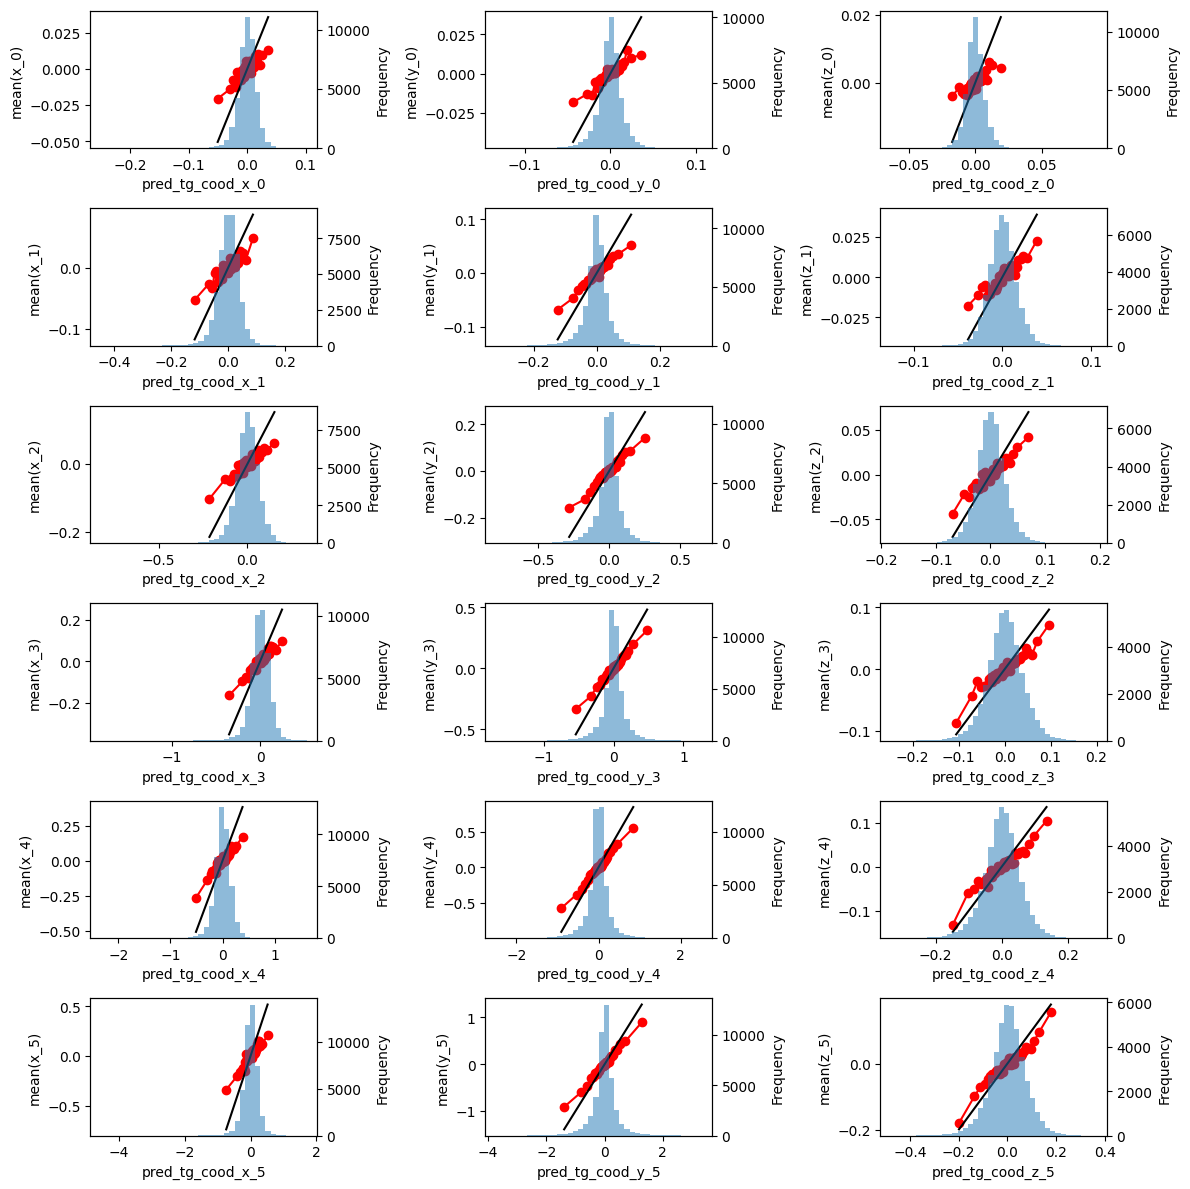

In [21]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

In [22]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    tr_df = add_base_pred_to_target(tr_df, TARGET_COLS)
    tr_df = add_base_pred_to_target(tr_df, pred_cols)

In [23]:
if BASE_PRED_DIR is not None:
    scores = calc_score(tr_df, pred_cols)
    display(scores)

{'score_pred_tg_cood_x_0': 0.060417555523930966,
 'score_pred_tg_cood_y_0': 0.03296804818543516,
 'score_pred_tg_cood_z_0': 0.026119078598162166,
 'score_pred_tg_cood_x_1': 0.12823329461807403,
 'score_pred_tg_cood_y_1': 0.07188169459858534,
 'score_pred_tg_cood_z_1': 0.05383160539340314,
 'score_pred_tg_cood_x_2': 0.2172090228299917,
 'score_pred_tg_cood_y_2': 0.1254693364791201,
 'score_pred_tg_cood_z_2': 0.08279707129930305,
 'score_pred_tg_cood_x_3': 0.33798148040562426,
 'score_pred_tg_cood_y_3': 0.20238585065991369,
 'score_pred_tg_cood_z_3': 0.11256151974206581,
 'score_pred_tg_cood_x_4': 0.4880829520807532,
 'score_pred_tg_cood_y_4': 0.3078154614833987,
 'score_pred_tg_cood_z_4': 0.14360310797770034,
 'score_pred_tg_cood_x_5': 0.661482808921574,
 'score_pred_tg_cood_y_5': 0.44163729800197676,
 'score_pred_tg_cood_z_5': 0.17620766917883376,
 'avg': 0.2039269364432137}

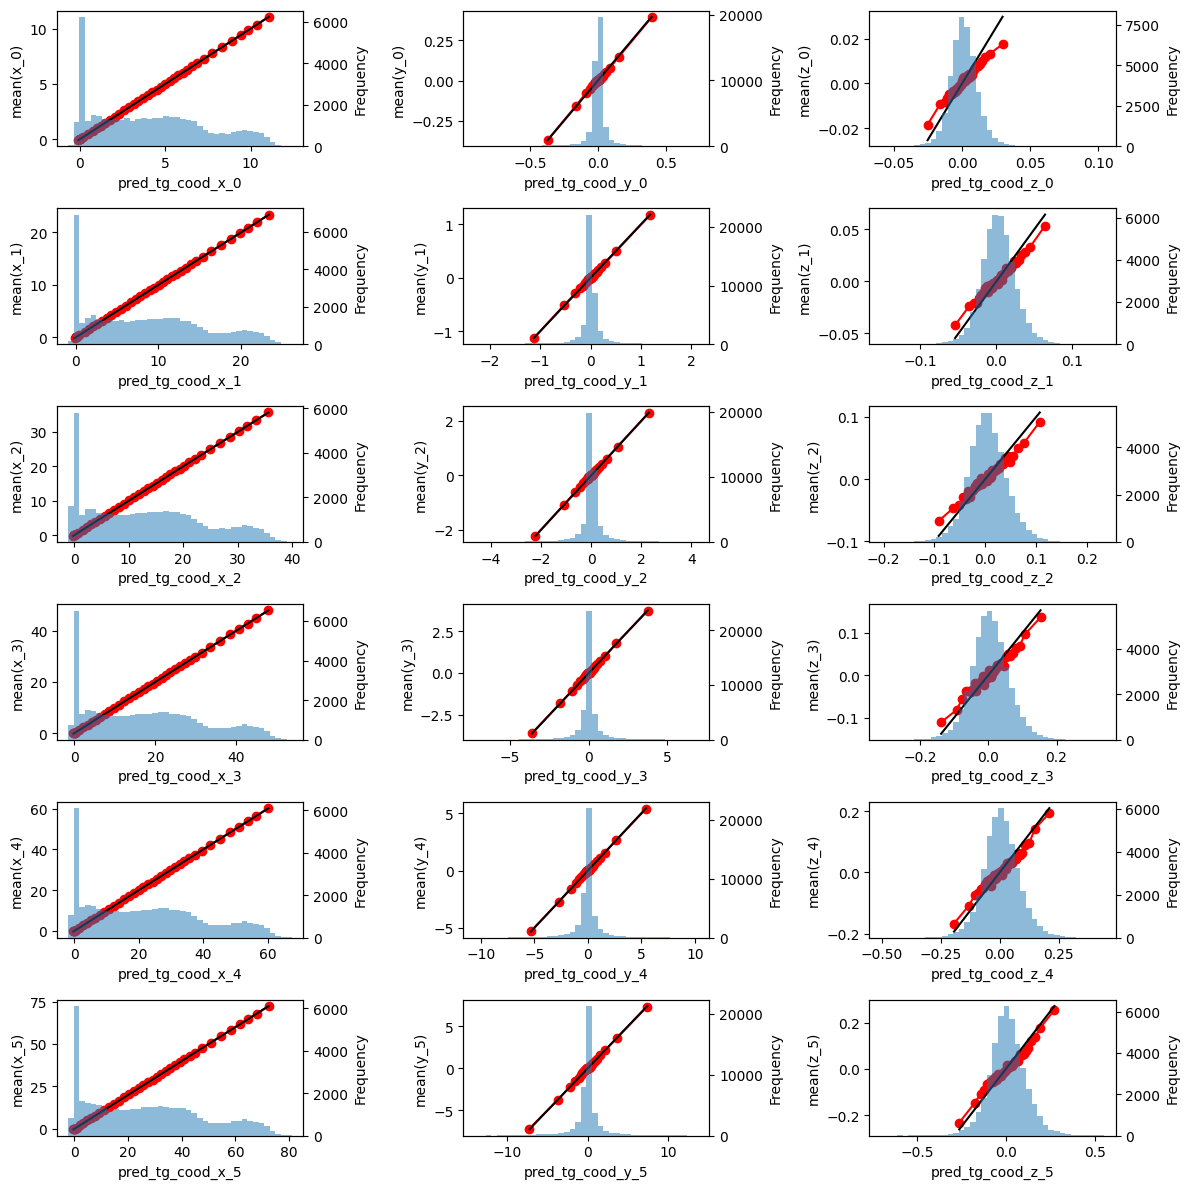

In [24]:
if BASE_PRED_DIR is not None:
    utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## oofを保存

In [25]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = TARGET_COLS

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


# 元の順番に戻して保存
create_submission_csv(tr_df.sort("origin_idx").select(pred_cols), "oof_preds.csv")

Submission file is created: oof_preds.csv


## Submission

In [26]:
preds = utils.predict(
    models,
    ts_images,
    ts_df,
    feature.columns,
    scene_id_col="scene_id",
    scene_dsec_col="scene_dsec",
    pred_cols=pred_cols,
)
pred_cols = preds.columns
ts_df = pl.concat([ts_df, preds], how="horizontal")

preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.010796,0.006192,-0.003074,0.048416,0.006222,0.008689,0.046807,0.027577,0.004222,0.103767,0.033028,0.006258,0.134985,0.06429,0.018807,0.25738,0.054746,0.016258
-0.008135,-0.001703,-0.002425,0.018271,0.021914,-0.008955,-0.010604,0.043202,-0.010006,-0.016193,0.08657,-0.021733,-0.060626,0.213513,-0.026705,-0.029306,0.333398,-0.047842
-0.001606,0.003762,-0.00948,0.006088,-0.00629,-0.014958,-0.008126,-0.009811,-0.01473,-0.053888,-0.020937,-0.043217,-0.001344,0.020526,-0.046948,-0.080814,-0.046786,-0.030302
-0.050843,-0.015503,0.000131,-0.110903,-0.044836,-0.004586,-0.199455,-0.062037,0.001628,-0.355215,-0.047011,0.002104,-0.453215,-0.091355,-0.034563,-0.872211,0.057367,0.006738
0.007167,0.002457,0.000703,0.012007,-0.000352,0.000624,0.027961,-0.00082,-0.001022,0.036381,0.016424,0.011829,0.083778,-0.00378,0.005209,0.113564,-0.007184,0.020462
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.015019,0.017016,-0.00366,0.061829,0.054258,-0.005866,0.100707,0.16866,-0.017244,0.188601,0.310014,-0.042133,0.279359,0.535681,-0.04264,0.374619,0.888804,-0.05242
-0.00713,0.017094,-0.012062,-0.009906,0.043577,-0.039063,0.003289,0.105259,-0.080618,0.009139,0.188648,-0.133982,-0.034136,0.270716,-0.197386,0.020686,0.348435,-0.2752
-0.006238,0.010996,0.008614,-0.036054,0.019216,0.018702,-0.051205,0.049508,0.033896,-0.089096,0.11382,0.042214,-0.19214,0.211076,0.049509,-0.254082,0.19862,0.080942


In [27]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    ts_df = add_base_pred_to_target(ts_df, pred_cols)
    display(ts_df)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,base_pred_y_1,base_pred_z_1,base_pred_x_2,base_pred_y_2,base_pred_z_2,base_pred_x_3,base_pred_y_3,base_pred_z_3,base_pred_x_4,base_pred_y_4,base_pred_z_4,base_pred_x_5,base_pred_y_5,base_pred_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,…,ft_rightBlinker,ft_base_pred_x0,ft_base_pred_y0,ft_base_pred_z0,ft_base_pred_x1,ft_base_pred_y1,ft_base_pred_z1,ft_base_pred_x2,ft_base_pred_y2,ft_base_pred_z2,ft_base_pred_x3,ft_base_pred_y3,ft_base_pred_z3,ft_base_pred_x4,ft_base_pred_y4,ft_base_pred_z4,ft_base_pred_x5,ft_base_pred_y5,ft_base_pred_z5,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0,1.4928,-0.047437,-0.000326,3.122828,-0.094562,-0.003115,4.703802,-0.159459,-0.005652,6.214634,-0.190779,-0.006373,7.652307,-0.179759,-0.009369,8.970826,-0.119019,-0.007873,3.374273,-0.01936,-34.008415,17.0,…,0.0,1.4928,-0.047437,-0.000326,3.122828,-0.094562,-0.003115,4.703802,-0.159459,-0.005652,6.214634,-0.190779,-0.006373,7.652307,-0.179759,-0.009369,8.970826,-0.119019,-0.007873,1.503596,-0.041245,-0.003399,3.171244,-0.08834,0.005574,4.750608,-0.131882,-0.00143,6.318401,-0.157751,-0.000114,7.787292,-0.115469,0.009438,9.228206,-0.064273,0.008385
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1,0.933565,0.392385,0.000336,1.814535,1.033601,0.003623,2.47108,1.776173,0.004562,3.011575,2.673704,0.008065,3.689159,3.759892,0.017334,4.346382,5.04043,0.030237,2.441048,-0.022754,307.860077,295.0,…,0.0,0.933565,0.392385,0.000336,1.814535,1.033601,0.003623,2.47108,1.776173,0.004562,3.011575,2.673704,0.008065,3.689159,3.759892,0.017334,4.346382,5.04043,0.030237,0.92543,0.390682,-0.002089,1.832806,1.055515,-0.005332,2.460476,1.819374,-0.005444,2.995382,2.760274,-0.013668,3.628533,3.973405,-0.009371,4.317076,5.373828,-0.017605
"""012baccc145d400c896cb82065a93d…",3.604152,-0.286239,10.774388,-110.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",320,2,1.615533,0.004321,0.00092,3.345943,-0.001811,0.000561,4.938106,-0.031779,-0.001101,6.459437,-0.012939,-0.001444,7.913136,-0.000395,-0.005522,9.219673,0.00669,-0.006699,3.604152,-0.286239,10.774388,-110.0,…,0.0,1.615533,0.004321,0.00092,3.345943,-0.001811,0.000561,4.938106,-0.031779,-0.001101,6.459437,-0.012939,-0.001444,7.913136,-0.000395,-0.005522,9.219673,0.00669,-0.006699,1.613927,0.008083,-0.00856,3.35203,-0.008101,-0.014398,4.92998,-0.041591,-0.015831,6.405549,-0.033876,-0.044662,7.911791,0.020132,-0.052469,9.138859,-0.040096,-0.037002
"""012baccc145d400c896cb82065a93d…",2.048902,-0.537628,61.045235,189.0,0.0,true,0.0,false,"""drive""",true,false,"""012baccc145d400c896cb82065a93d…",420,3,0.857725,0.066614,-0.005757,1.710414,0.188786,-0.01204,2.464009,0.37251,-0.017823,3.084059,0.624366,-0.025491,3.671909,1.03626,-0.036196,4.27187,1.577337,-0.050439,2.048902,-0.537628,61.045235,189.0,…,0.0,0.857725,0.066614,-0.005757,1.710414,0.188786,-0.01204,2.464009,0.37251,-0.017823,3.084059,0.624366,-0.025491,3.671909,1.03626,-0.036196,4.27187,1.577337,-0.050439,0.806882,0

In [28]:
# 元の順番に戻す
ts_df = ts_df.sort("origin_idx")

In [29]:
create_submission_csv(ts_df.select(pred_cols), "submission.csv")

Submission file is created: submission.csv
